In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes

In [2]:
# Read in all orders.
orders = pd.read_csv('superstore_dataset2011-2015.csv', header=0, encoding='ISO-8859-1')

In [3]:
# Display dataset's data types.
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

In [4]:
orders = orders.drop_duplicates()

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

In [6]:
# Dsiplay the dataset's number of rows and columns pre-formatting
orders.shape

(51290, 24)

In [7]:
# Display the dataset's basic stat.
orders.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.00000,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000


In [8]:
# Checking for null fields
df_null = round(100*(orders.isnull().sum())/len(orders), 2)
df_null

Row ID             0.00
Order ID           0.00
Order Date         0.00
Ship Date          0.00
Ship Mode          0.00
Customer ID        0.00
Customer Name      0.00
Segment            0.00
City               0.00
State              0.00
Country            0.00
Postal Code       80.51
Market             0.00
Region             0.00
Product ID         0.00
Category           0.00
Sub-Category       0.00
Product Name       0.00
Sales              0.00
Quantity           0.00
Discount           0.00
Profit             0.00
Shipping Cost      0.00
Order Priority     0.00
dtype: float64

# Profit-Sales-ShippingCost

In [9]:
# Profit column
profit_column = orders.groupby('City')['Profit'].sum()
profit_column = profit_column.reset_index()
profit_column.columns = ['City', 'Profit']
profit_column.head()

,City,Profit
0,Aachen,1116.981
1,Aalen,283.005
2,Aalst,152.310
3,Aba,-1475.556
4,Abadan,233.820


In [10]:
# Sales column
sales_column = orders.groupby('City')['Sales'].sum()
sales_column = sales_column.reset_index()
sales_column.columns = ['City', 'Sales']
sales_column.head()

,City,Sales
0,Aachen,3803.151
1,Aalen,979.695
2,Aalst,387.330
3,Aba,1064.124
4,Abadan,1354.950


In [11]:
# Shipping Cost column
shippingCost_column = orders.groupby('City')['Shipping Cost'].sum()
shippingCost_column = shippingCost_column.reset_index()
shippingCost_column.columns = ['City', 'ShippingCost']
shippingCost_column.head()

,City,ShippingCost
0,Aachen,391.28
1,Aalen,81.97
2,Aalst,30.19
3,Aba,122.45
4,Abadan,116.22


In [12]:
# Merging dataframes
profit_sales = pd.merge(profit_column, sales_column, on='City', how='inner')
profit_sales_shippingCost = pd.merge(profit_sales, shippingCost_column, on='City', how='inner')
profit_sales_shippingCost.columns = ['City', 'Profit', 'Sales', 'ShippingCost']
profit_sales_shippingCost.head()

,City,Profit,Sales,ShippingCost
0,Aachen,1116.981,3803.151,391.28
1,Aalen,283.005,979.695,81.97
2,Aalst,152.310,387.330,30.19
3,Aba,-1475.556,1064.124,122.45
4,Abadan,233.820,1354.950,116.22


Text(0.5, 0, 'Attributes')

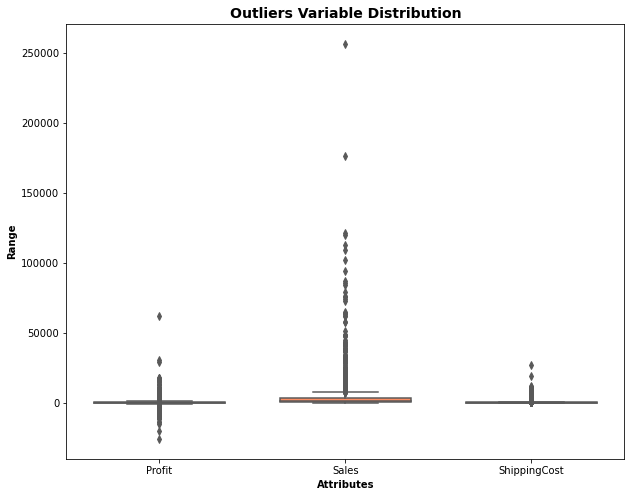

In [13]:
# Detect outliers

attributes = ['Profit','Sales','ShippingCost']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = profit_sales_shippingCost[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

(-15000.0, 15000.0)

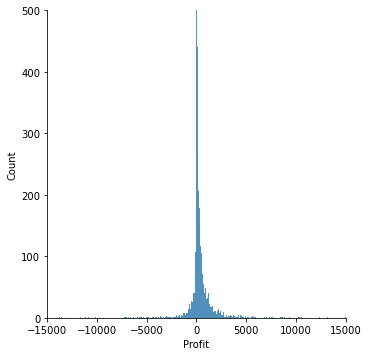

In [14]:
sns.displot(profit_sales_shippingCost['Profit'])
plt.ylim(0, 500)
plt.xlim(-15000, 15000)

(0.0, 15000.0)

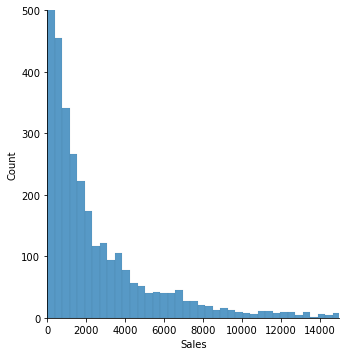

In [15]:
sns.displot(profit_sales_shippingCost['Sales'])
plt.ylim(0, 500)
plt.xlim(0, 15000)

(0.0, 15000.0)

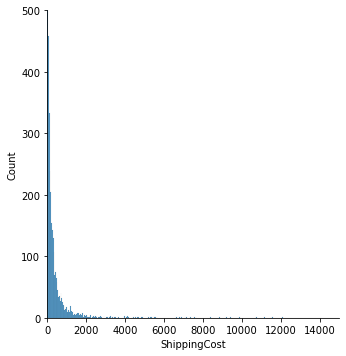

In [16]:
sns.displot(profit_sales_shippingCost['ShippingCost'])
plt.ylim(0, 500)
plt.xlim(0, 15000)

In [17]:
# Removing (statistical) outliers for Sales
Q1 = profit_sales_shippingCost.Sales.quantile(0.25)
Q3 = profit_sales_shippingCost.Sales.quantile(0.75)
IQR = Q3 - Q1
rfm = profit_sales_shippingCost[(profit_sales_shippingCost.Sales >= Q1 - 1.5*IQR) & (profit_sales_shippingCost.Sales <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Shipping Cost
Q1 = profit_sales_shippingCost.ShippingCost.quantile(0.25)
Q3 = profit_sales_shippingCost.ShippingCost.quantile(0.75)
IQR = Q3 - Q1
rfm = profit_sales_shippingCost[(profit_sales_shippingCost.ShippingCost >= Q1 - 1.5*IQR) & (profit_sales_shippingCost.ShippingCost <= Q3 + 1.5*IQR)]

(-15000.0, 15000.0)

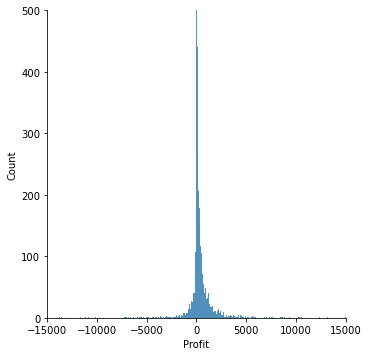

In [18]:
sns.displot(profit_sales_shippingCost['Profit'])
plt.ylim(0, 500)
plt.xlim(-15000, 15000)

(0.0, 15000.0)

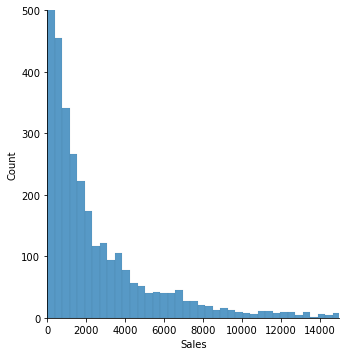

In [19]:
sns.displot(profit_sales_shippingCost['Sales'])
plt.ylim(0, 500)
plt.xlim(0, 15000)

(0.0, 15000.0)

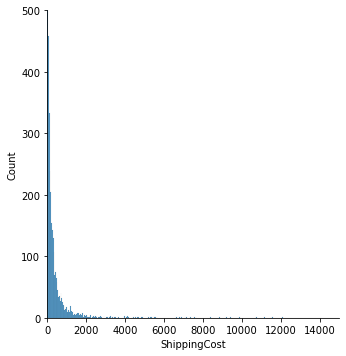

In [20]:
sns.displot(profit_sales_shippingCost['ShippingCost'])
plt.ylim(0, 500)
plt.xlim(0, 15000)

In [21]:
# Rescaling the attributes

psc = profit_sales_shippingCost[['Profit', 'Sales', 'ShippingCost']]

# Instantiate
scaler = MinMaxScaler()

# fit_transform
psc_scaled = scaler.fit_transform(psc)
psc_scaled.shape

(3636, 3)

In [22]:
psc_scaled = pd.DataFrame(psc_scaled)
psc_scaled.columns = ['Profit', 'Sales', 'ShippingCost']
psc_scaled.head()

,Profit,Sales,ShippingCost
0,0.307408,0.014829,0.014516
1,0.297927,0.003816,0.003038
2,0.296441,0.001505,0.001117
3,0.277934,0.004145,0.004541
4,0.297368,0.005280,0.004309


Text(0, 0.5, 'Average within Cluster Sum Of Squares')

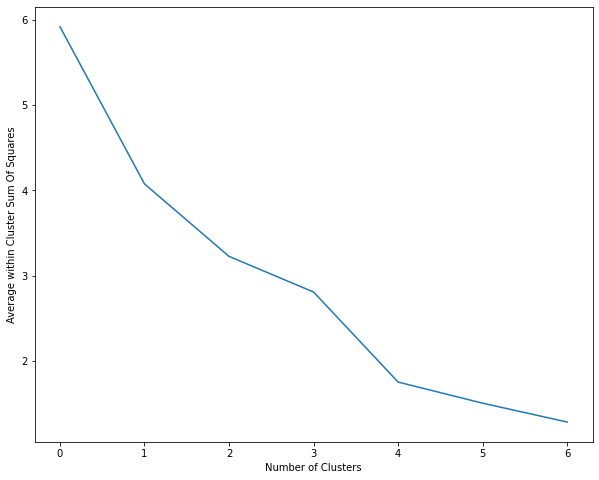

In [23]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, init='random', algorithm='elkan')
    kmeans.fit(psc_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
plt.xlabel('Number of Clusters')
plt.ylabel('Average within Cluster Sum Of Squares')
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [24]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, init='random', algorithm='elkan')
    kmeans.fit(psc_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(psc_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.9303563385577867
For n_clusters=3, the silhouette score is 0.8277006069610854
For n_clusters=4, the silhouette score is 0.713982282329861
For n_clusters=5, the silhouette score is 0.7140380799630057
For n_clusters=6, the silhouette score is 0.6855947899637531
For n_clusters=7, the silhouette score is 0.6208916381702443
For n_clusters=8, the silhouette score is 0.6209471860095215


In [25]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50, init='random', algorithm='elkan')
kmeans.fit(psc_scaled)

KMeans(algorithm='elkan', init='random', max_iter=50, n_clusters=4)

In [26]:
 kmeans.labels_

array([2, 2, 2, ..., 2, 2, 2])

In [27]:
# assign the label
psc['Cluster_Id'] = kmeans.labels_
psc.head()

,Profit,Sales,ShippingCost,Cluster_Id
0,1116.981,3803.151,391.28,2
1,283.005,979.695,81.97,2
2,152.310,387.330,30.19,2
3,-1475.556,1064.124,122.45,2
4,233.820,1354.950,116.22,2


<AxesSubplot:xlabel='Cluster_Id', ylabel='Profit'>

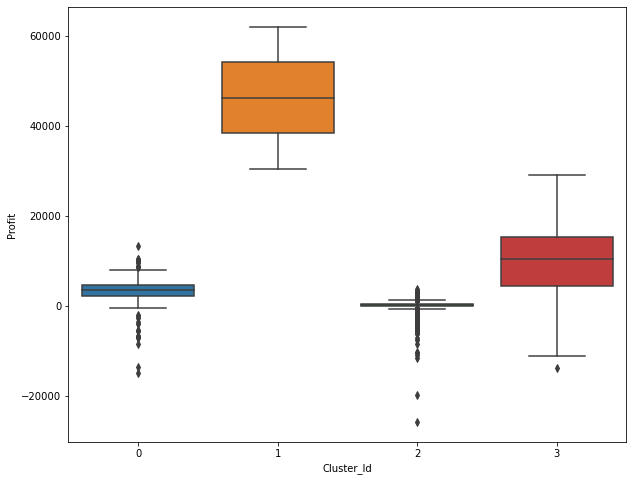

In [28]:
# Box plot to visualize Cluster Id vs Profit

sns.boxplot(x='Cluster_Id', y='Profit', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Sales'>

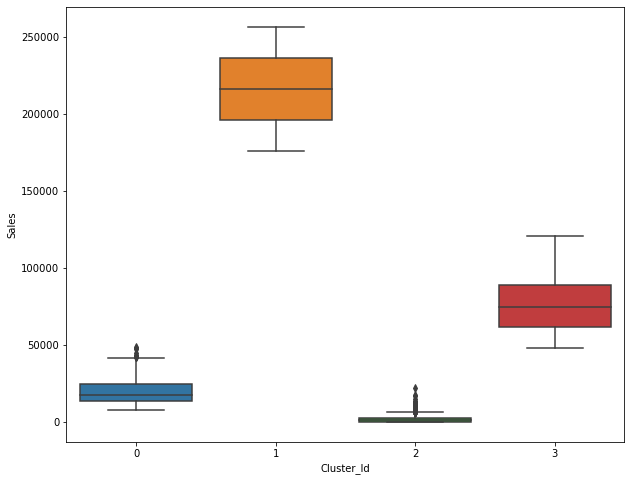

In [29]:
# Box plot to visualize Cluster Id vs Sales

sns.boxplot(x='Cluster_Id', y='Sales', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='ShippingCost'>

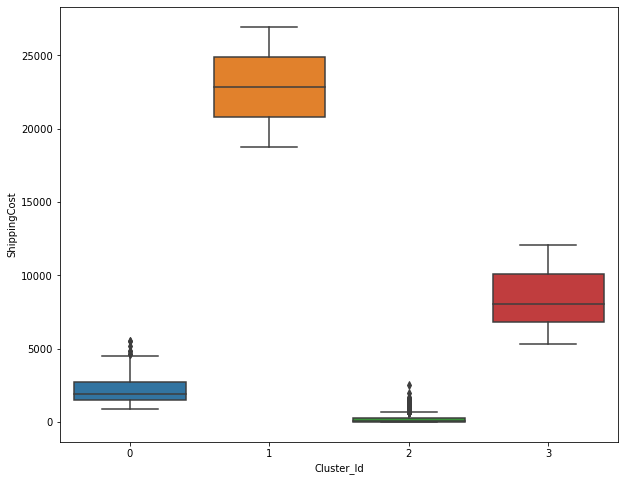

In [30]:
# Box plot to visualize Cluster Id vs Shipping Cost

sns.boxplot(x='Cluster_Id', y='ShippingCost', data=psc)

Text(0, 0.5, 'Average within Cluster Sum Of Squares')

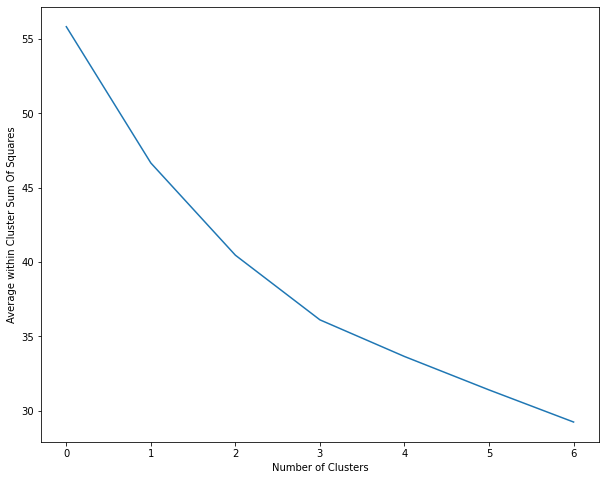

In [31]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50, method='pam')
    kmedoids.fit(psc_scaled)
    
    ssd.append(kmedoids.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
plt.xlabel('Number of Clusters')
plt.ylabel('Average within Cluster Sum Of Squares')
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [32]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50, method='pam')
    kmedoids.fit(psc_scaled)
    
    cluster_labels = kmedoids.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(psc_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.6278010736392924
For n_clusters=3, the silhouette score is 0.5926872496150054
For n_clusters=4, the silhouette score is 0.4648899175929373
For n_clusters=5, the silhouette score is 0.43888416557236487
For n_clusters=6, the silhouette score is 0.3431243511722141
For n_clusters=7, the silhouette score is 0.3535063035731479
For n_clusters=8, the silhouette score is 0.3986867827934289


In [79]:
# Final model with k=4
kmedoids = KMedoids(n_clusters=4, max_iter=50, init='build', method='pam')
kmedoids.fit(psc_scaled)

KMedoids(init='build', max_iter=50, method='pam', n_clusters=4)

In [80]:
# assign the label
psc['Cluster_Id'] = kmedoids.labels_
psc.head()

,Profit,Sales,ShippingCost,Cluster_Id
0,1116.981,3803.151,391.28,3
1,283.005,979.695,81.97,0
2,152.310,387.330,30.19,0
3,-1475.556,1064.124,122.45,0
4,233.820,1354.950,116.22,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Profit'>

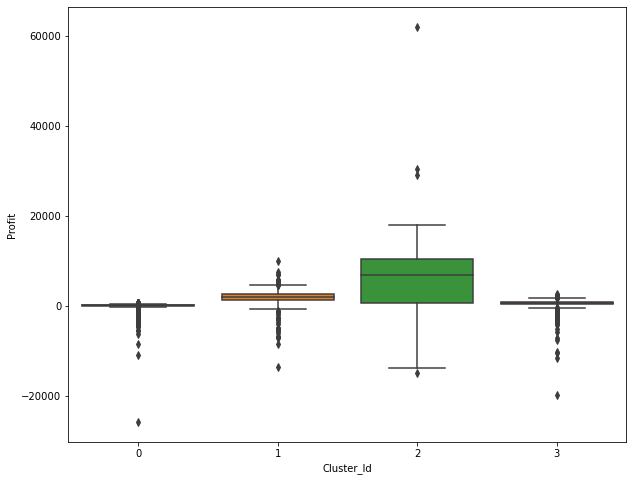

In [81]:
# Box plot to visualize Cluster Id vs Profit

sns.boxplot(x='Cluster_Id', y='Profit', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Sales'>

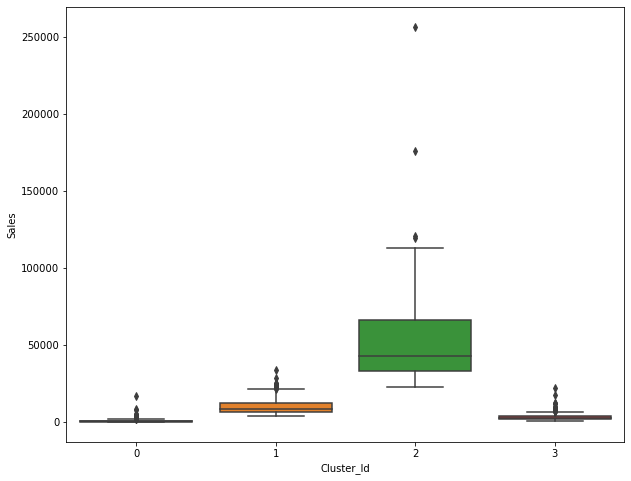

In [82]:
# Box plot to visualize Cluster Id vs Sales

sns.boxplot(x='Cluster_Id', y='Sales', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='ShippingCost'>

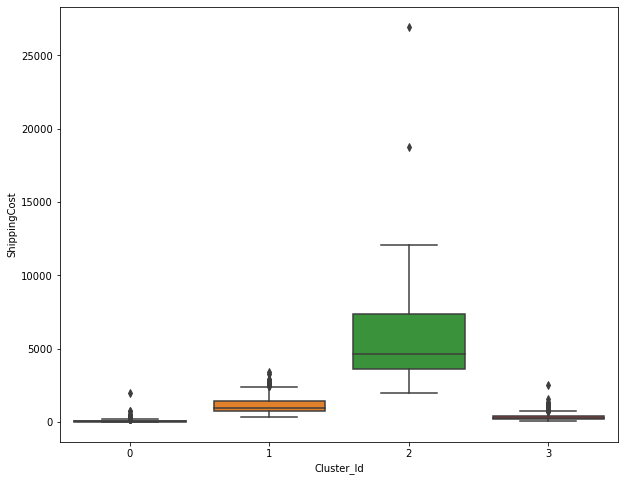

In [83]:
# Box plot to visualize Cluster Id vs Shipping Cost

sns.boxplot(x='Cluster_Id', y='ShippingCost', data=psc)

In [68]:
# Choose cities in Group 2 (high profit, high shipping cost) whose profit is at least at the 25th quartile
Q1 = psc.Profit.quantile(0.25)
psc_0 = psc.loc[(psc['Cluster_Id'] == 1) & (psc.Profit >= Q1)]
psc_0.sort_values(by=['ShippingCost'], ascending=False)

,Profit,Sales,ShippingCost,Cluster_Id
2290,62036.98370,256368.16100,26948.17,1
1910,30440.75790,175851.34100,18777.07,1
2936,29156.09670,119540.74200,11581.45,1
3107,16002.80700,101945.51700,11183.66,1
2843,17507.38540,112669.09200,10753.24,1
1508,3826.98420,94321.32420,10735.47,1
1895,17378.71500,86945.80500,9890.22,1
1989,17853.71804,83707.49804,9393.94,1
2106,13342.29176,85728.55176,8860.27,1
1202,4453.78200,72626.92200,8824.94,1


In [69]:
# Retrieve the cities whose high value orders from psc_0's index
high_orders = profit_sales_shippingCost[profit_sales_shippingCost.index.isin(psc_0.index)].sort_values(by=['ShippingCost'], ascending=False)

In [70]:
# Generate the countries that each unique city match with.
country_city = orders[['Country', 'City']].copy().drop_duplicates()

In [71]:
# Inner join between high_orders and country_city to get the countries high value order cities belong to.
high_orders = high_orders.merge(right=country_city, how='inner', on='City')
high_orders

,City,Profit,Sales,ShippingCost,Country
0,New York City,62036.98370,256368.16100,26948.17,United States
1,Los Angeles,30440.75790,175851.34100,18777.07,United States
2,Seattle,29156.09670,119540.74200,11581.45,United States
3,Sydney,16002.80700,101945.51700,11183.66,Australia
4,San Francisco,17507.38540,112669.09200,10753.24,United States
5,Jakarta,3826.98420,94321.32420,10735.47,Indonesia
6,London,17378.71500,86945.80500,9890.22,United Kingdom
7,London,17378.71500,86945.80500,9890.22,Canada
8,Managua,17853.71804,83707.49804,9393.94,Nicaragua
9,Mexico City,13342.29176,85728.55176,8860.27,Mexico


In [72]:
high_orders.describe()

,Profit,Sales,ShippingCost
count,24.000000,24.000000,24.000000
mean,15276.643307,85983.838769,9270.436667
std,11895.749156,46175.501574,4774.572753
min,3826.984200,47898.409560,5305.680000
25%,8599.009500,60912.601875,6800.927500
50%,11843.430300,73939.164000,7981.690000
75%,17378.715000,88789.684800,10101.532500
max,62036.983700,256368.161000,26948.170000


In [73]:
high_orders.groupby('Country')['City'].count()

Country
Australia         7
Austria           1
Canada            1
El Salvador       1
France            1
Germany           1
Guatemala         1
Indonesia         1
Mexico            1
Nicaragua         1
South Africa      1
Spain             1
United Kingdom    1
United States     5
Name: City, dtype: int64

Text(0, 0.5, 'Average within Cluster Sum Of Squares')

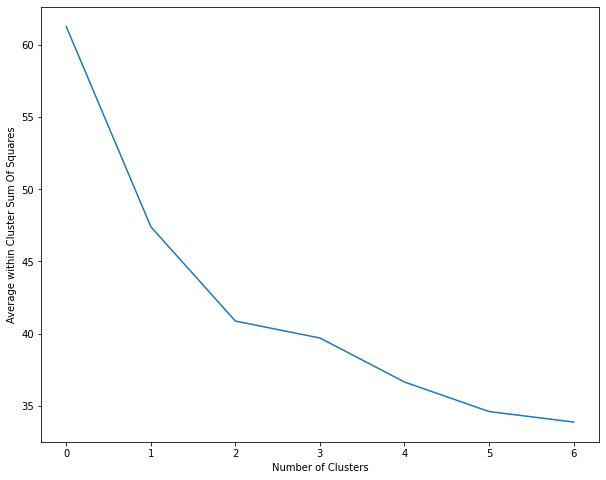

In [45]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50, init='k-medoids++', method='alternate')
    kmedoids.fit(psc_scaled)
    
    ssd.append(kmedoids.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
plt.xlabel('Number of Clusters')
plt.ylabel('Average within Cluster Sum Of Squares')
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [46]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50, init='k-medoids++', method='alternate')
    kmedoids.fit(psc_scaled)
    
    cluster_labels = kmedoids.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(psc_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.9000305743940722
For n_clusters=3, the silhouette score is 0.6201405608088065
For n_clusters=4, the silhouette score is 0.5947859121833637
For n_clusters=5, the silhouette score is 0.6241321978846571
For n_clusters=6, the silhouette score is 0.5560647342688255
For n_clusters=7, the silhouette score is 0.5477014516465263
For n_clusters=8, the silhouette score is 0.46686141516522384


In [74]:
# Final model with k=4
kmedoids = KMedoids(n_clusters=4, max_iter=50, init='k-medoids++', method='alternate')
kmedoids.fit(psc_scaled)

KMedoids(init='k-medoids++', max_iter=50, n_clusters=4)

In [75]:
# assign the label
psc['Cluster_Id'] = kmedoids.labels_
psc.head()

,Profit,Sales,ShippingCost,Cluster_Id
0,1116.981,3803.151,391.28,1
1,283.005,979.695,81.97,0
2,152.310,387.330,30.19,0
3,-1475.556,1064.124,122.45,0
4,233.820,1354.950,116.22,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Profit'>

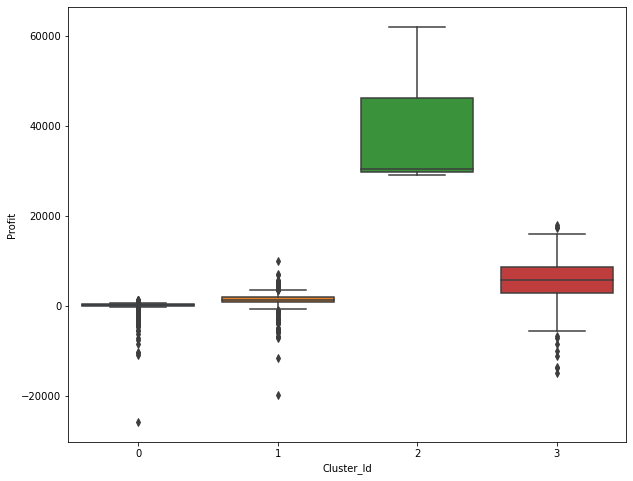

In [76]:
# Box plot to visualize Cluster Id vs Profit

sns.boxplot(x='Cluster_Id', y='Profit', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Sales'>

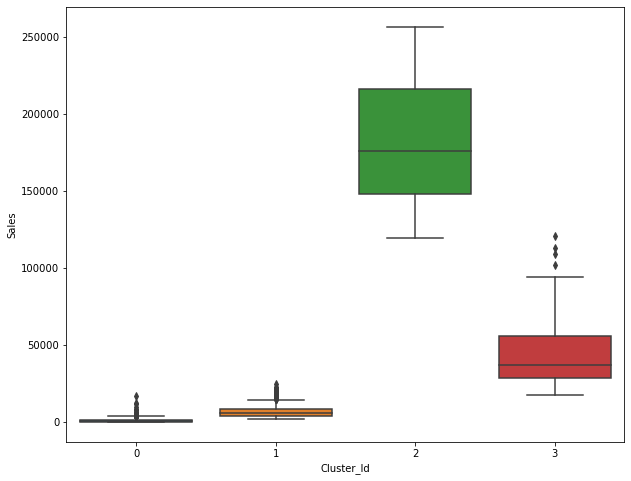

In [77]:
# Box plot to visualize Cluster Id vs Sales

sns.boxplot(x='Cluster_Id', y='Sales', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='ShippingCost'>

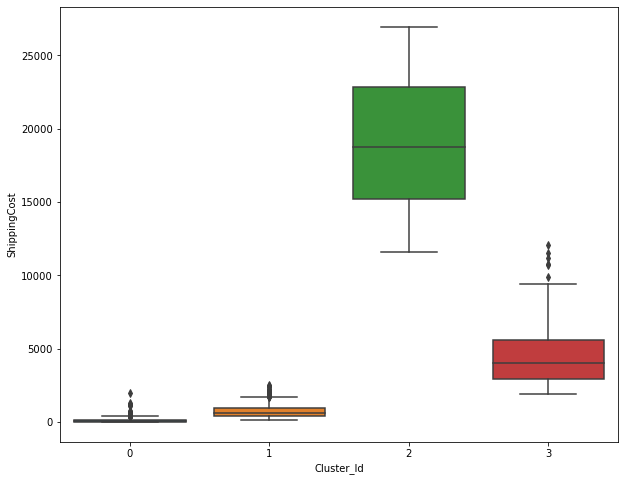

In [78]:
# Box plot to visualize Cluster Id vs Shipping Cost

sns.boxplot(x='Cluster_Id', y='ShippingCost', data=psc)